In [76]:
#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os.path as osp
import random
from typing import Dict,List

import gym.spaces as spaces
import hydra
import numpy as np
import torch
from hydra.utils import instantiate as hydra_instantiate
from omegaconf import DictConfig
from rl_utils.envs import create_vectorized_envs
from rl_utils.logging import Logger
from tensordict.tensordict import TensorDict
from torchrl.envs.utils import step_mdp
from typing import Tuple
from imitation_learning.common.evaluator import Evaluator

In [78]:
from snake_env import SnakeEnv 

In [79]:
import yaml 
cfg = yaml.load(open("bc-irl-snake.yaml", 'r'), Loader=yaml.SafeLoader)
cfg = DictConfig(cfg)

In [80]:
cfg

{'env_settings': {}, 'obs_shape': '???', 'action_dim': '???', 'total_num_updates': '???', 'action_is_discrete': '???', 'num_steps': 50, 'num_envs': 128, 'device': 'cpu', 'only_eval': False, 'seed': 3, 'num_eval_episodes': 100, 'num_env_steps': 20000000, 'recurrent_hidden_state_size': 128, 'gamma': 0.8, 'log_interval': 10, 'eval_interval': 400, 'save_interval': 10000000000, 'load_checkpoint': None, 'load_policy': True, 'resume_training': False, 'policy': {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 128, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': '${obs_shape}', 'action_dim': '${action_dim}', 'action_is_discrete': '${action_is_discrete}', 'std_init': -1, 'num_envs': '${num_envs}', 'squash_mean': True}, 'policy_updater': {'_target_': 'imitation_learning.bcirl.BCIRL', '_recursive_': False, 'use_clipped_value_loss': True, 'clip_param': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.0001, 'max_grad_norm': -1, 'num_epochs': 2, 'num_mini_bat

In [81]:

def set_seed(seed: int) -> None:
    """
    Sets the seed for numpy, python random, and pytorch.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [82]:
from gymnasium import Env
class vectorized_env():
    def __init__(self, envs : List[Env]):
        self.envs = envs
        self.num_envs = len(self.envs)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space

    def reset(self):

        return torch.tensor([env.reset()[0].tolist() for env in self.envs],dtype=torch.float32)
    
    def step(self, action) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[Dict]]:
        steps = [env.step(action[i]) for i,env in enumerate(self.envs)]
        return_value = (torch.tensor([step[0].tolist() for step in steps],dtype=torch.float32),
                torch.tensor([step[1] for step in steps],dtype=torch.float32),
                torch.tensor([step[2] for step in steps],dtype=torch.bool),
                [step[3] for step in steps])
        return return_value
    
    def render(self, mode = "rgb_array"):
        if(self.envs[0].render_mode == "rgb_array"):
            return [env.render(mode) for env in self.envs]
        else:
            self.envs[0].render(mode)

In [83]:
set_seed(cfg.seed)

device = torch.device(cfg.device)

# Setup the environments
set_env_settings = {
    k: hydra_instantiate(v) if isinstance(v, DictConfig) else v
    for k, v in cfg.env.env_settings.items()
}
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

steps_per_update = cfg.num_steps * cfg.num_envs

num_updates = int(cfg.num_env_steps) // steps_per_update

# Set dynamic variables in the config.
cfg.obs_shape = envs.observation_space.shape
cfg.action_dim = envs.action_space.shape[0]
cfg.action_is_discrete = isinstance(cfg.action_dim, spaces.Discrete)
cfg.total_num_updates = num_updates

logger: Logger = hydra_instantiate(cfg.logger, full_cfg=cfg)
print("policy",cfg.policy)
policy = hydra_instantiate(cfg.policy)
policy = policy.to(device)
print("policy_updater",cfg.policy_updater)
updater = hydra_instantiate(cfg.policy_updater, policy=policy, device=device)


Assigning full prefix 63-3-U5MAdd
policy {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 128, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': [4], 'action_dim': 4, 'action_is_discrete': False, 'std_init': -1, 'num_envs': 128, 'squash_mean': True}
policy_updater {'_target_': 'imitation_learning.bcirl.BCIRL', '_recursive_': False, 'use_clipped_value_loss': True, 'clip_param': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.0001, 'max_grad_norm': -1, 'num_epochs': 2, 'num_mini_batch': 4, 'num_envs': '${num_envs}', 'num_steps': '${num_steps}', 'gae_lambda': 0.95, 'gamma': '${gamma}', 'optimizer_params': {'_target_': 'torch.optim.Adam', 'lr': 0.0003}, 'batch_size': 256, 'plot_interval': '${eval_interval}', 'norm_expert_actions': False, 'n_inner_iters': 1, 'reward_update_freq': 1, 'device': '${device}', 'total_num_updates': '${total_num_updates}', 'use_lr_decay': True, 'lr_decay_rate': -1.0, 'get_dataset_fn': {'_target_': 'imitation_learning.common

In [84]:

start_update = 0
if cfg.load_checkpoint is not None:
    # Load a checkpoint for the policy/reward. Also potentially resume
    # training.
    ckpt = torch.load(cfg.load_checkpoint)
    updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
    if cfg.load_policy:
        policy.load_state_dict(ckpt["policy"])
    if cfg.resume_training:
        start_update = ckpt["update_i"] + 1

eval_info = {"run_name": logger.run_name}


In [85]:
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

tensor([0.1000, 0.9000, 0.5000, 0.8000])

Updates 0, Steps 6400, FPS 7043
Over the last 10 episodes:
    - episode.reward: -0.10368438344268213
    - episode.score: 0.0
    - episode.distance_to_goal: 0.43076948661341846
    - inferred_episode_reward: -0.7701053380966186
    - value_loss: 0.22034435532987118
    - action_loss: -0.021339304556022398
    - dist_entropy: 1.675754427909851
    - irl_loss: 0.28015026450157166
    - reward_lr: 0.001


<Figure size 640x480 with 0 Axes>

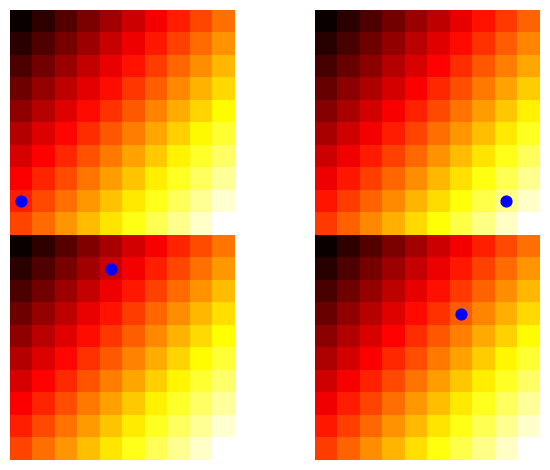


Updates 10, Steps 70400, FPS 12661
Over the last 10 episodes:
    - episode.reward: -0.10004579092000945
    - episode.score: 0.0
    - episode.distance_to_goal: 0.41065092699891437
    - inferred_episode_reward: 4.1309857532382015
    - value_loss: 3.4872366905212404
    - action_loss: -0.0013382699340581893
    - dist_entropy: 1.676353645324707
    - irl_loss: 0.27234523594379423
    - reward_lr: 0.0009982399999999998


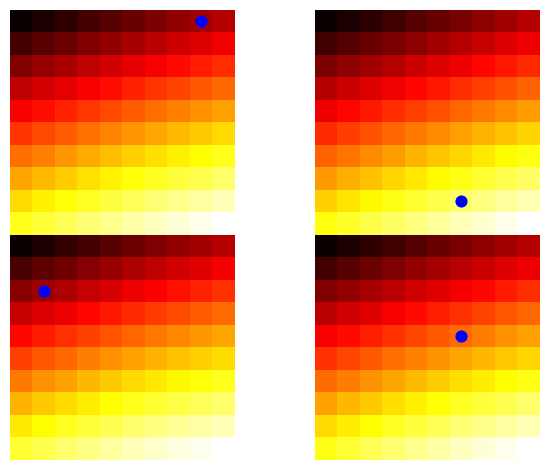


Updates 20, Steps 134400, FPS 12488
Over the last 10 episodes:
    - episode.reward: 0.004414874449577202
    - episode.score: 0.0
    - episode.distance_to_goal: 0.33922881581613895
    - inferred_episode_reward: 3.8500371396541597
    - value_loss: 4.0405103921890255
    - action_loss: 0.004419075348414481
    - dist_entropy: 1.675754427909851
    - irl_loss: 0.2563891440629959
    - reward_lr: 0.0009950400000000002


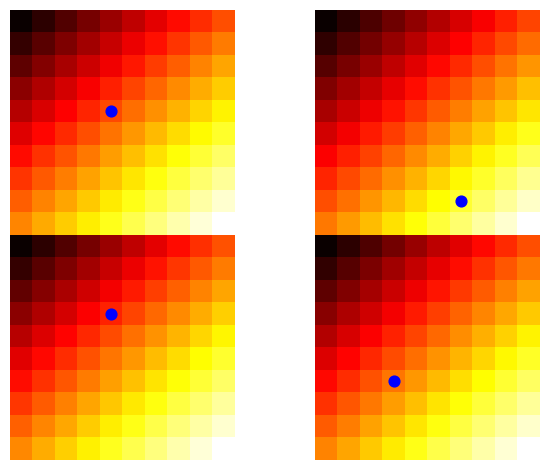


Updates 30, Steps 198400, FPS 12681
Over the last 10 episodes:
    - episode.reward: -0.001917255831709308
    - episode.score: 0.0
    - episode.distance_to_goal: 0.41193786770711893
    - inferred_episode_reward: 0.37336833477020265
    - value_loss: 3.5319258689880373
    - action_loss: 0.004855565191246569
    - dist_entropy: 1.6759544610977173
    - irl_loss: 0.25127133578062055
    - reward_lr: 0.0009918400000000003


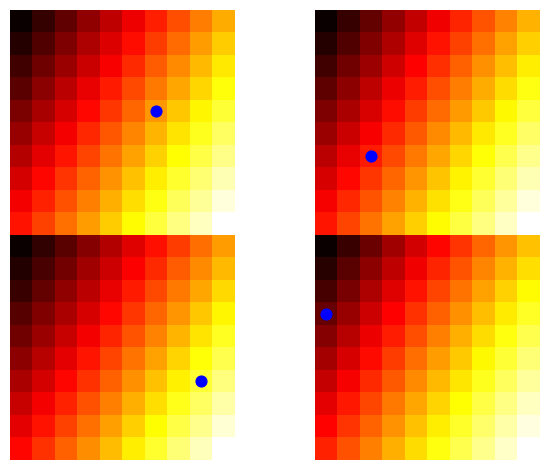


Updates 40, Steps 262400, FPS 12537
Over the last 10 episodes:
    - episode.reward: -0.20235388301247412
    - episode.score: 0.0
    - episode.distance_to_goal: 0.41001736974851555
    - inferred_episode_reward: 3.4483407929539682
    - value_loss: 6.524942350387573
    - action_loss: -0.002984687755815685
    - dist_entropy: 1.676594090461731
    - irl_loss: 0.2599379330873489
    - reward_lr: 0.0009886400000000003


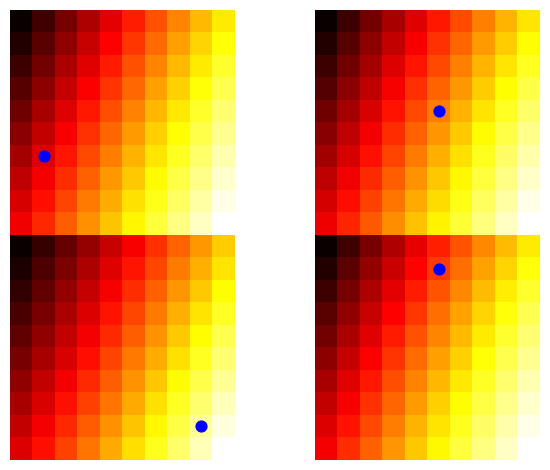


Updates 50, Steps 326400, FPS 12485
Over the last 10 episodes:
    - episode.reward: -0.0015591299028835971
    - episode.score: 0.0
    - episode.distance_to_goal: 0.46375391220088397
    - inferred_episode_reward: 8.558371269702912
    - value_loss: 37.506646728515626
    - action_loss: -0.0038103520637378097
    - dist_entropy: 1.6769545078277588
    - irl_loss: 0.2644136667251587
    - reward_lr: 0.0009854400000000002


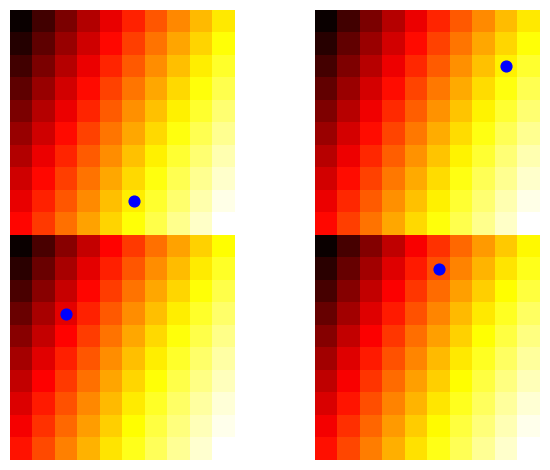


Updates 60, Steps 390400, FPS 12869
Over the last 10 episodes:
    - episode.reward: -0.10230179643825085
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4416775830140168
    - inferred_episode_reward: 14.970785570144653
    - value_loss: 69.83316345214844
    - action_loss: -0.00763797746039927
    - dist_entropy: 1.677154541015625
    - irl_loss: 0.265269273519516
    - reward_lr: 0.0009822400000000001


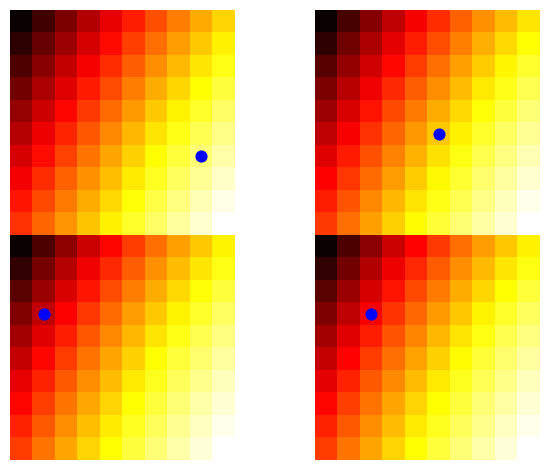


Updates 70, Steps 454400, FPS 11909
Over the last 10 episodes:
    - episode.reward: -0.10314529535745705
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3725682236818922
    - inferred_episode_reward: 20.45625628232956
    - value_loss: 93.40583038330078
    - action_loss: -0.007439720199909061
    - dist_entropy: 1.6779549598693848
    - irl_loss: 0.26500297486782076
    - reward_lr: 0.00097904


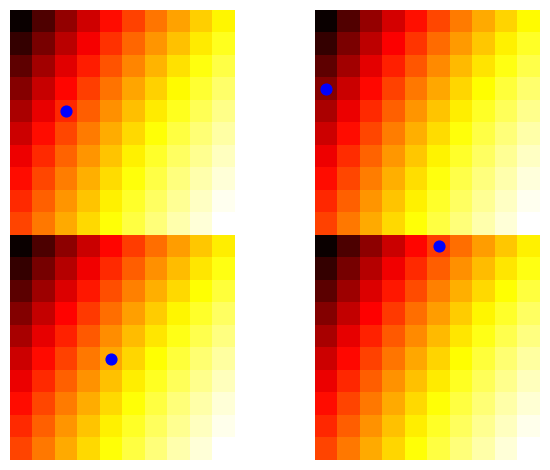


Updates 80, Steps 518400, FPS 11475
Over the last 10 episodes:
    - episode.reward: -0.09640178774580126
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3692033578661383
    - inferred_episode_reward: 16.147059392929076
    - value_loss: 113.47356491088867
    - action_loss: 0.004412769572809339
    - dist_entropy: 1.6773545742034912
    - irl_loss: 0.27058881521224976
    - reward_lr: 0.0009758400000000001


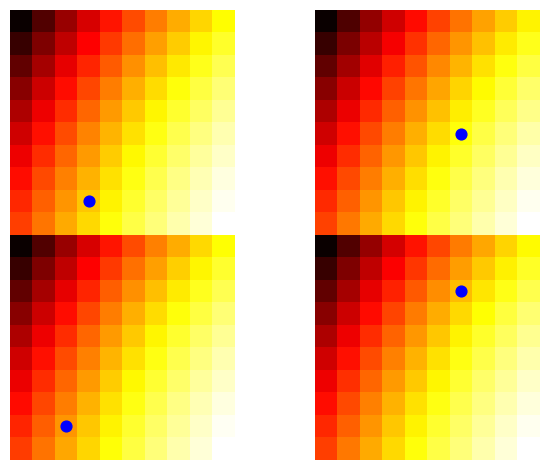


Updates 90, Steps 582400, FPS 11106
Over the last 10 episodes:
    - episode.reward: -0.20228940047134283
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4337660130985803
    - inferred_episode_reward: 35.296663069725035
    - value_loss: 123.58950347900391
    - action_loss: 0.009804256167262793
    - dist_entropy: 1.6771546602249146
    - irl_loss: 0.26437781751155853
    - reward_lr: 0.0009726400000000001


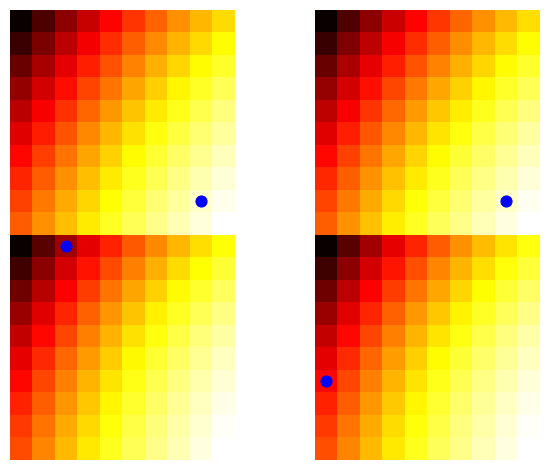


Updates 100, Steps 646400, FPS 11534
Over the last 10 episodes:
    - episode.reward: -0.20013349263175337
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4098226253282496
    - inferred_episode_reward: 38.93179183006286
    - value_loss: 130.83367614746095
    - action_loss: -0.006735712778754533
    - dist_entropy: 1.6773546934127808
    - irl_loss: 0.26083295941352846
    - reward_lr: 0.0009694399999999999


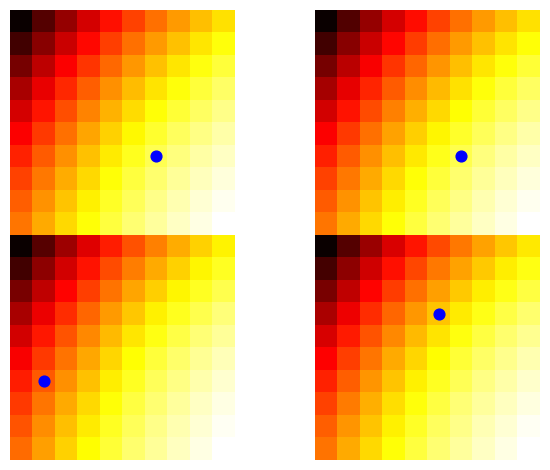


Updates 110, Steps 710400, FPS 11619
Over the last 10 episodes:
    - episode.reward: 0.0016366871512438388
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3716589118675566
    - inferred_episode_reward: 23.47850022315979
    - value_loss: 134.0583053588867
    - action_loss: -0.0001746909925714135
    - dist_entropy: 1.6779151439666748
    - irl_loss: 0.25979965925216675
    - reward_lr: 0.0009662399999999999


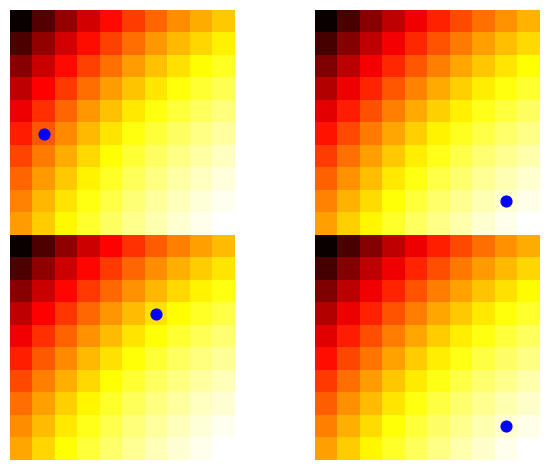


Updates 120, Steps 774400, FPS 11634
Over the last 10 episodes:
    - episode.reward: -0.0029708891685803866
    - episode.score: 0.0
    - episode.distance_to_goal: 0.32130577750399103
    - inferred_episode_reward: 39.18320209980011
    - value_loss: 130.0073028564453
    - action_loss: 0.007017486775293946
    - dist_entropy: 1.679475450515747
    - irl_loss: 0.2653015613555908
    - reward_lr: 0.0009630400000000001


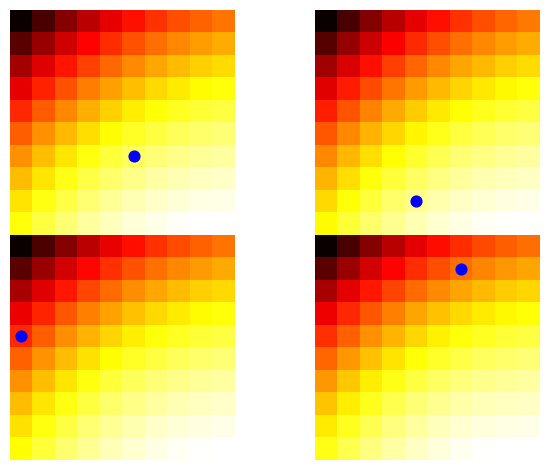


Updates 130, Steps 838400, FPS 11581
Over the last 10 episodes:
    - episode.reward: -0.10212949056022061
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4185700746661804
    - inferred_episode_reward: 25.155090594291686
    - value_loss: 122.09850006103515
    - action_loss: -0.004973855742719024
    - dist_entropy: 1.6803151607513427
    - irl_loss: 0.26430208086967466
    - reward_lr: 0.00095984


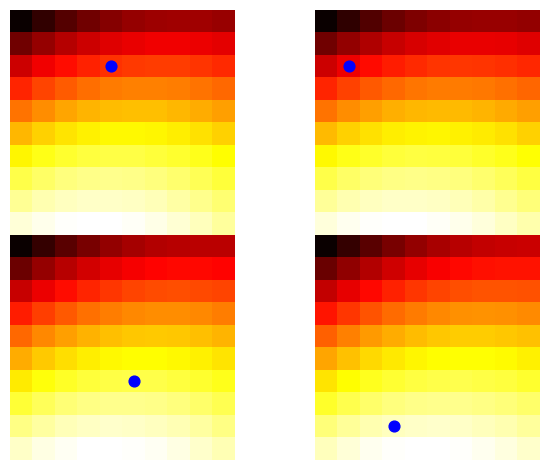


Updates 140, Steps 902400, FPS 10943
Over the last 10 episodes:
    - episode.reward: -0.09850272906462595
    - episode.score: 0.0
    - episode.distance_to_goal: 0.33241919782242785
    - inferred_episode_reward: 26.735951614379882
    - value_loss: 113.01896209716797
    - action_loss: -0.00432386938482523
    - dist_entropy: 1.680355191230774
    - irl_loss: 0.2620715618133545
    - reward_lr: 0.0009566400000000001


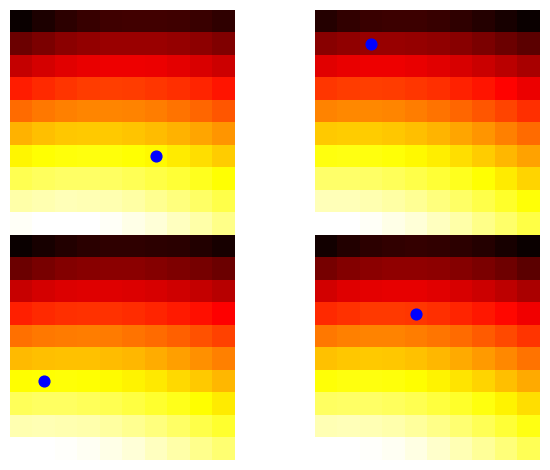


Updates 150, Steps 966400, FPS 11386
Over the last 10 episodes:
    - episode.reward: -0.001374146814115335
    - episode.score: 0.0
    - episode.distance_to_goal: 0.42700401237243746
    - inferred_episode_reward: 39.55958595275879
    - value_loss: 91.88164672851562
    - action_loss: -0.001084396429359913
    - dist_entropy: 1.680995488166809
    - irl_loss: 0.25858902335166933
    - reward_lr: 0.0009534400000000001


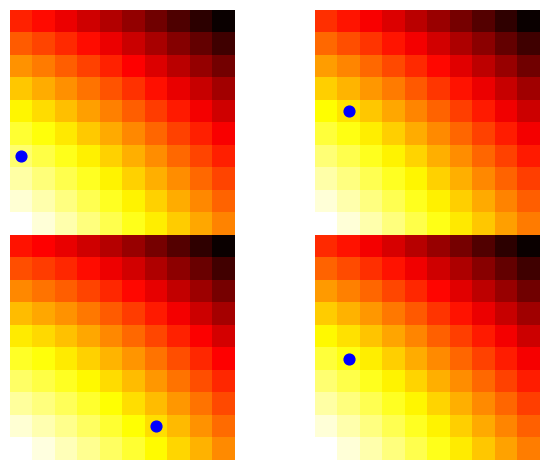


Updates 160, Steps 1030400, FPS 10270
Over the last 10 episodes:
    - episode.reward: -0.19941680963435063
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3521826333095396
    - inferred_episode_reward: 11.769715559482574
    - value_loss: 55.50113983154297
    - action_loss: 0.0007141504902392626
    - dist_entropy: 1.6815152168273926
    - irl_loss: 0.25247433334589003
    - reward_lr: 0.00095024


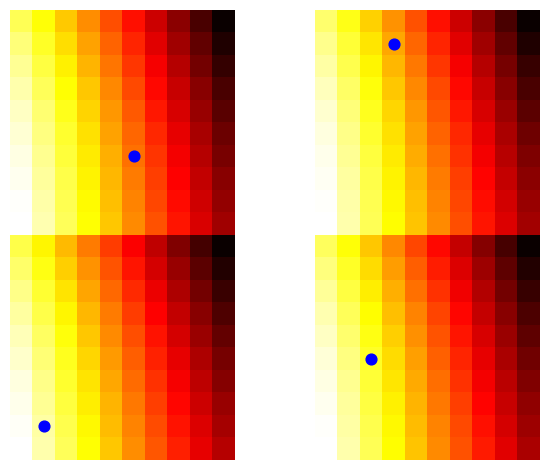


Updates 170, Steps 1094400, FPS 11512
Over the last 10 episodes:
    - episode.reward: 0.10085723433320934
    - episode.score: 0.1
    - episode.distance_to_goal: 0.29073889402037933
    - inferred_episode_reward: 12.024683570861816
    - value_loss: 39.74050025939941
    - action_loss: -0.008579753746744245
    - dist_entropy: 1.6813950538635254
    - irl_loss: 0.24765943586826325
    - reward_lr: 0.00094704


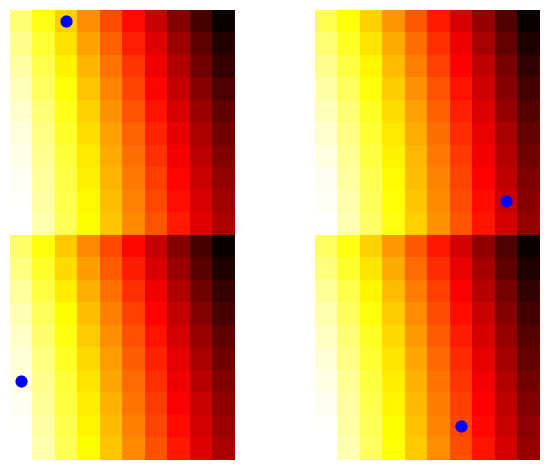


Updates 180, Steps 1158400, FPS 11172
Over the last 10 episodes:
    - episode.reward: 0.0031069231814053904
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3442406428431771
    - inferred_episode_reward: 25.731494414806367
    - value_loss: 116.17060623168945
    - action_loss: 0.0037392156664282084
    - dist_entropy: 1.6801550149917603
    - irl_loss: 0.24737310260534287
    - reward_lr: 0.0009438399999999999


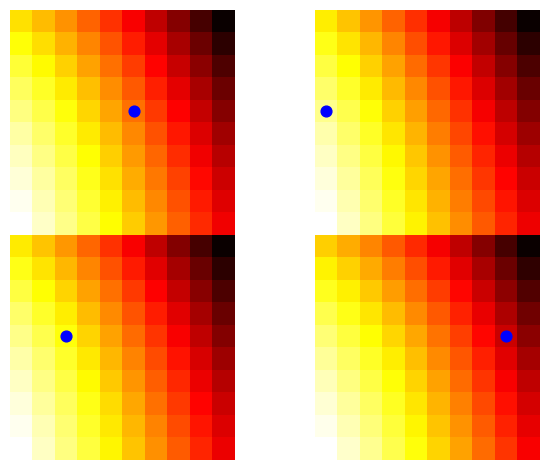


Updates 190, Steps 1222400, FPS 11200
Over the last 10 episodes:
    - episode.reward: 0.00013787171115269367
    - episode.score: 0.1
    - episode.distance_to_goal: 0.4078128295346545
    - inferred_episode_reward: 22.302014923095705
    - value_loss: 118.4577033996582
    - action_loss: 0.005382955621462316
    - dist_entropy: 1.6799947023391724
    - irl_loss: 0.24665938913822175
    - reward_lr: 0.0009406399999999999


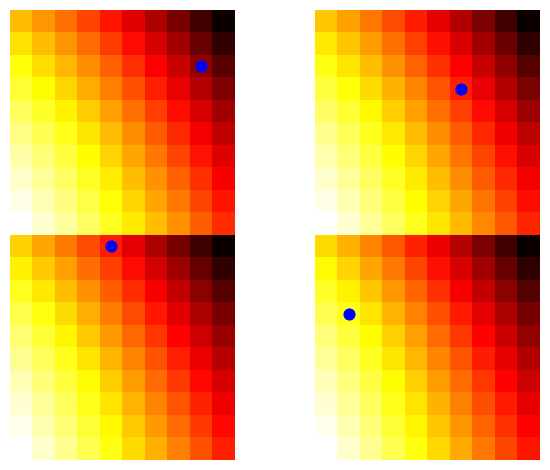


Updates 200, Steps 1286400, FPS 11335
Over the last 10 episodes:
    - episode.reward: -0.1013556753665978
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3538884035879414
    - inferred_episode_reward: 30.251679265499114
    - value_loss: 90.04339752197265
    - action_loss: 0.000280391750857234
    - dist_entropy: 1.6801550388336182
    - irl_loss: 0.25013633221387865
    - reward_lr: 0.00093744


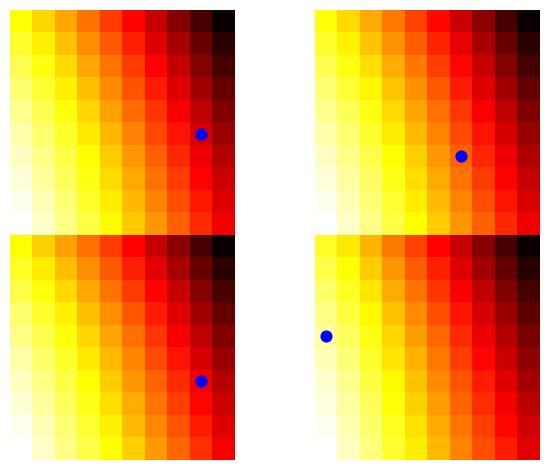


Updates 210, Steps 1350400, FPS 11486
Over the last 10 episodes:
    - episode.reward: 0.004301823717603179
    - episode.score: 0.0
    - episode.distance_to_goal: 0.35494610974220875
    - inferred_episode_reward: 8.229212057590484
    - value_loss: 42.85182762145996
    - action_loss: -0.009575900773052126
    - dist_entropy: 1.6799950122833252
    - irl_loss: 0.2473562777042389
    - reward_lr: 0.0009342399999999999


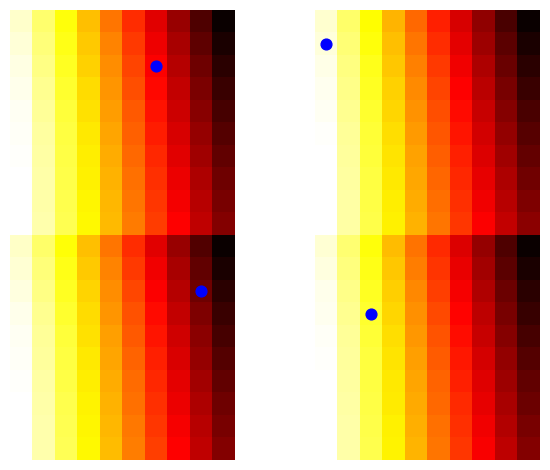


Updates 220, Steps 1414400, FPS 11751
Over the last 10 episodes:
    - episode.reward: -0.19894379076698016
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3811775728692579
    - inferred_episode_reward: 15.78256289958954
    - value_loss: 48.81355094909668
    - action_loss: -0.005147679918445646
    - dist_entropy: 1.6801151275634765
    - irl_loss: 0.24847996979951859
    - reward_lr: 0.00093104


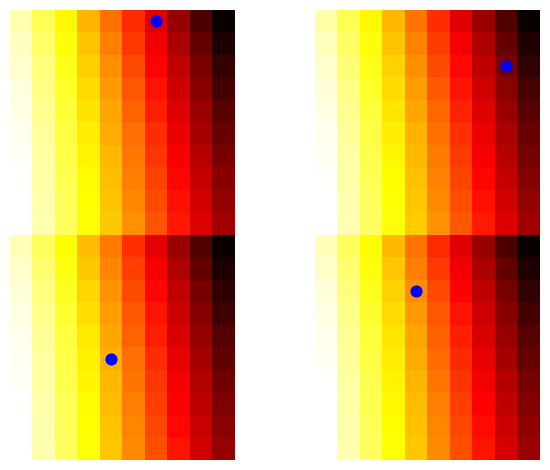


Updates 230, Steps 1478400, FPS 11520
Over the last 10 episodes:
    - episode.reward: -0.29867797738056234
    - episode.score: 0.0
    - episode.distance_to_goal: 0.38208045299202903
    - inferred_episode_reward: 35.336188995838164
    - value_loss: 105.4593620300293
    - action_loss: 0.014145199162885546
    - dist_entropy: 1.6792351961135865
    - irl_loss: 0.25061829686164855
    - reward_lr: 0.0009278399999999999


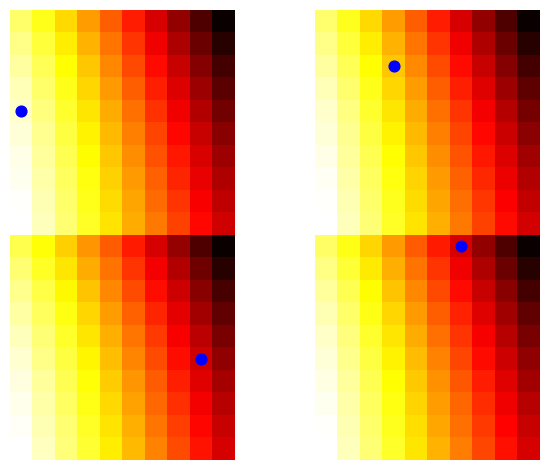


Updates 240, Steps 1542400, FPS 11620
Over the last 10 episodes:
    - episode.reward: -0.30194800049205356
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4256119038112386
    - inferred_episode_reward: 22.521919190883636
    - value_loss: 99.77545700073242
    - action_loss: -0.023075632960535587
    - dist_entropy: 1.678795337677002
    - irl_loss: 0.2464718133211136
    - reward_lr: 0.00092464


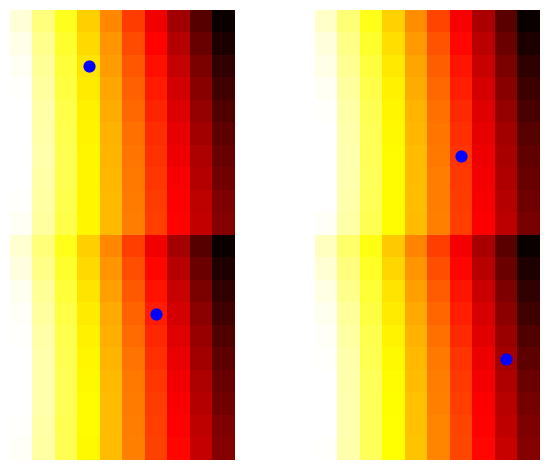


Updates 250, Steps 1606400, FPS 11637
Over the last 10 episodes:
    - episode.reward: -0.19794626431691154
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3780516963351748
    - inferred_episode_reward: 36.27660326957702
    - value_loss: 100.91025161743164
    - action_loss: 0.0007731249672360719
    - dist_entropy: 1.6787559509277343
    - irl_loss: 0.24400872141122817
    - reward_lr: 0.0009214400000000001


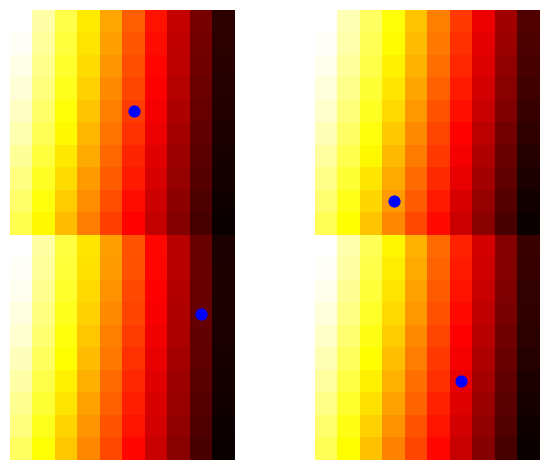


Updates 260, Steps 1670400, FPS 11594
Over the last 10 episodes:
    - episode.reward: 0.002015994776836378
    - episode.score: 0.0
    - episode.distance_to_goal: 0.33334543356612023
    - inferred_episode_reward: 28.690094542503356
    - value_loss: 92.21736907958984
    - action_loss: 0.0011558084515854716
    - dist_entropy: 1.6789156913757324
    - irl_loss: 0.24693158715963365
    - reward_lr: 0.0009182400000000001


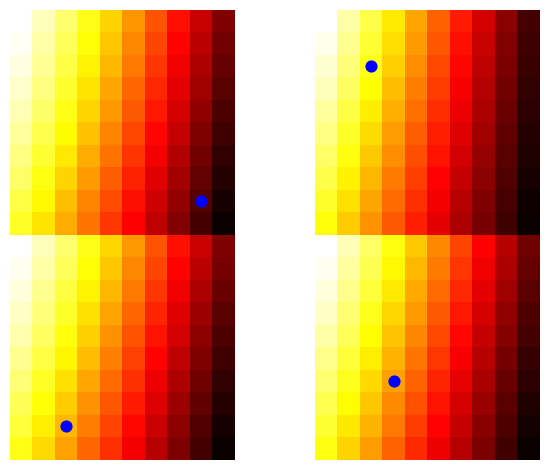


Updates 270, Steps 1734400, FPS 11477
Over the last 10 episodes:
    - episode.reward: -0.003928960426632662
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4347127034533499
    - inferred_episode_reward: 35.80050048828125
    - value_loss: 96.88715133666992
    - action_loss: 0.0035101316869258882
    - dist_entropy: 1.6783958435058595
    - irl_loss: 0.2526634529232979
    - reward_lr: 0.0009150400000000001


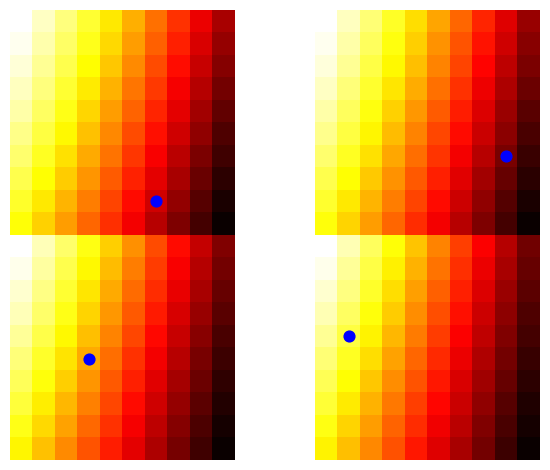


Updates 280, Steps 1798400, FPS 11069
Over the last 10 episodes:
    - episode.reward: -0.10315790784473242
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3464245954260322
    - inferred_episode_reward: 21.241128158569335
    - value_loss: 102.51885986328125
    - action_loss: 0.008424880355596543
    - dist_entropy: 1.6794757127761841
    - irl_loss: 0.25346383154392244
    - reward_lr: 0.00091184


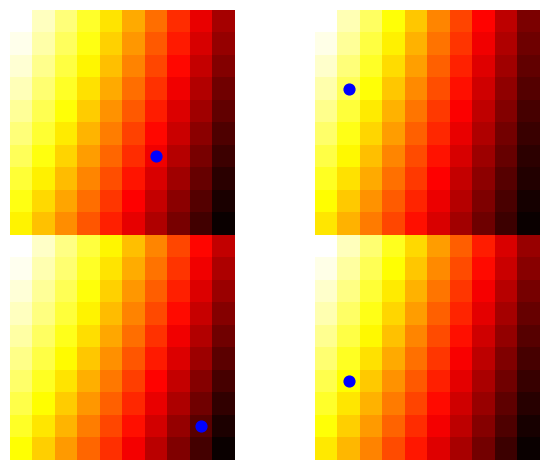


Updates 290, Steps 1862400, FPS 11578
Over the last 10 episodes:
    - episode.reward: -0.0009752951305811965
    - episode.score: 0.0
    - episode.distance_to_goal: 0.37807933194118626
    - inferred_episode_reward: 15.649456667900086
    - value_loss: 119.79003677368163
    - action_loss: 0.005849473690614104
    - dist_entropy: 1.6799561977386475
    - irl_loss: 0.2513169586658478
    - reward_lr: 0.00090864


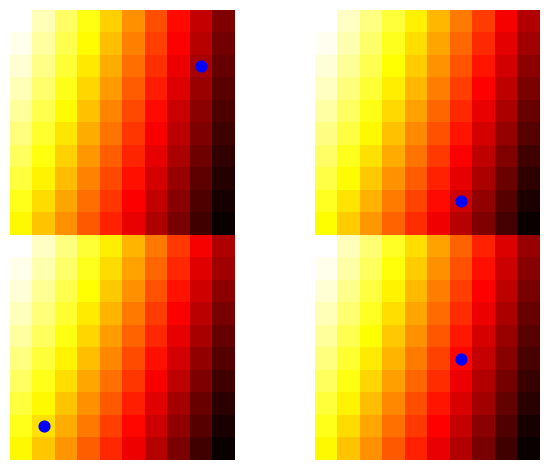


Updates 300, Steps 1926400, FPS 11272
Over the last 10 episodes:
    - episode.reward: -0.20059483624515445
    - episode.score: 0.0
    - episode.distance_to_goal: 0.42092120164199354
    - inferred_episode_reward: 19.999874305725097
    - value_loss: 118.4524932861328
    - action_loss: 0.0052604105847422035
    - dist_entropy: 1.6815165042877198
    - irl_loss: 0.2562516272068024
    - reward_lr: 0.0009054400000000001


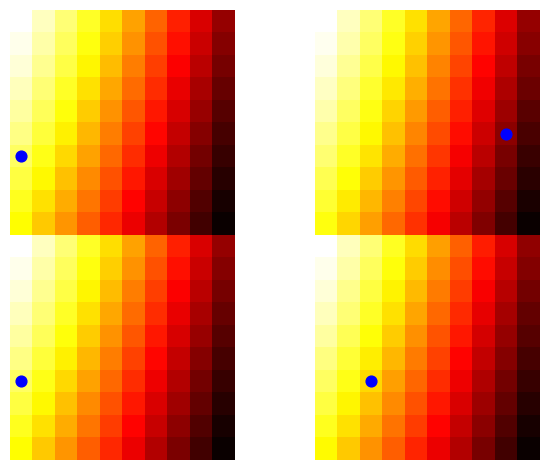


Updates 310, Steps 1990400, FPS 11470
Over the last 10 episodes:
    - episode.reward: -0.3054632166216146
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4077345360727887
    - inferred_episode_reward: 27.342813467979433
    - value_loss: 114.81437683105469
    - action_loss: 0.011093427427113056
    - dist_entropy: 1.681396198272705
    - irl_loss: 0.2615532010793686
    - reward_lr: 0.00090224


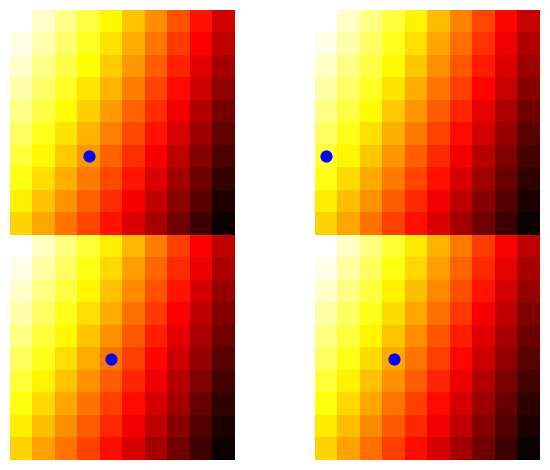


Updates 320, Steps 2054400, FPS 9979
Over the last 10 episodes:
    - episode.reward: -0.09851212064841319
    - episode.score: 0.1
    - episode.distance_to_goal: 0.3396948703235005
    - inferred_episode_reward: 22.07008066177368
    - value_loss: 115.71714782714844
    - action_loss: 0.003418446099385619
    - dist_entropy: 1.68255615234375
    - irl_loss: 0.2610170513391495
    - reward_lr: 0.00089904


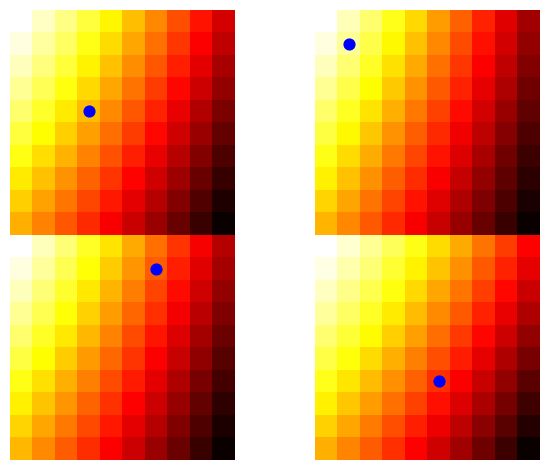


Updates 330, Steps 2118400, FPS 10634
Over the last 10 episodes:
    - episode.reward: -0.003450475756850911
    - episode.score: 0.0
    - episode.distance_to_goal: 0.44192148435359935
    - inferred_episode_reward: 25.090987110137938
    - value_loss: 108.4939178466797
    - action_loss: -0.0031298318412154914
    - dist_entropy: 1.6816364049911499
    - irl_loss: 0.2678833335638046
    - reward_lr: 0.00089584


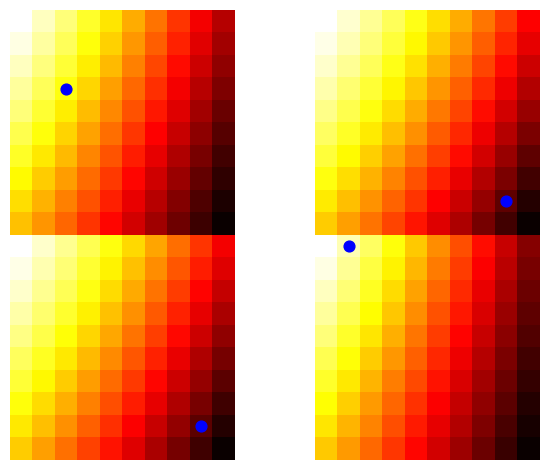


Updates 340, Steps 2182400, FPS 10627
Over the last 10 episodes:
    - episode.reward: -0.20706618781758648
    - episode.score: 0.0
    - episode.distance_to_goal: 0.42843003553563513
    - inferred_episode_reward: 22.94959490299225
    - value_loss: 109.92521057128906
    - action_loss: -0.0010322835325496272
    - dist_entropy: 1.680996036529541
    - irl_loss: 0.271974703669548
    - reward_lr: 0.0008926400000000001


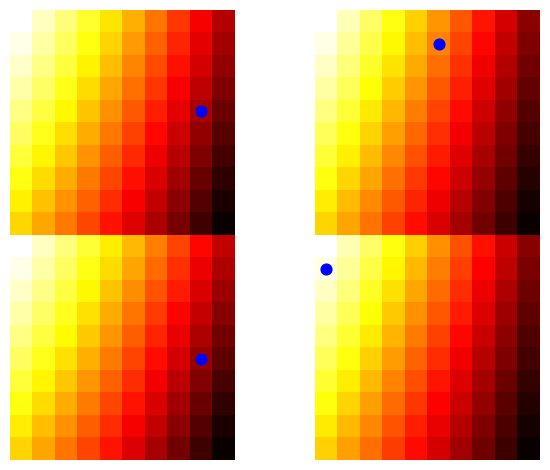


Updates 350, Steps 2246400, FPS 10695
Over the last 10 episodes:
    - episode.reward: -0.001136784902230217
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39842514945279706
    - inferred_episode_reward: 28.947347140312196
    - value_loss: 88.9451072692871
    - action_loss: -0.0025077966798562556
    - dist_entropy: 1.6815565824508667
    - irl_loss: 0.26947379410266875
    - reward_lr: 0.00088944


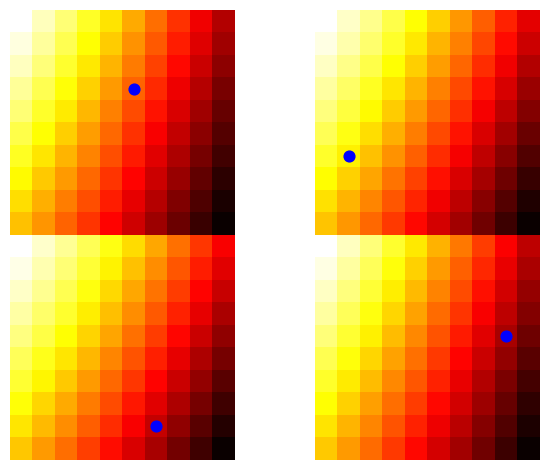


Updates 360, Steps 2310400, FPS 12063
Over the last 10 episodes:
    - episode.reward: -0.09992318155807302
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39588396964687744
    - inferred_episode_reward: 33.12364749908447
    - value_loss: 75.40270233154297
    - action_loss: 0.0011659669689834118
    - dist_entropy: 1.6807160377502441
    - irl_loss: 0.27839601039886475
    - reward_lr: 0.0008862399999999999


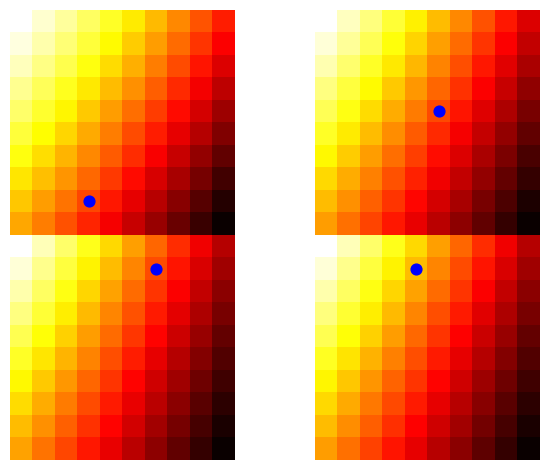


Updates 370, Steps 2374400, FPS 10282
Over the last 10 episodes:
    - episode.reward: 0.11121780298436701
    - episode.score: 0.1
    - episode.distance_to_goal: 0.26830543505787796
    - inferred_episode_reward: 23.758605647087098
    - value_loss: 62.52805099487305
    - action_loss: 0.015005149485659786
    - dist_entropy: 1.6801961183547973
    - irl_loss: 0.28473205864429474
    - reward_lr: 0.0008830400000000001


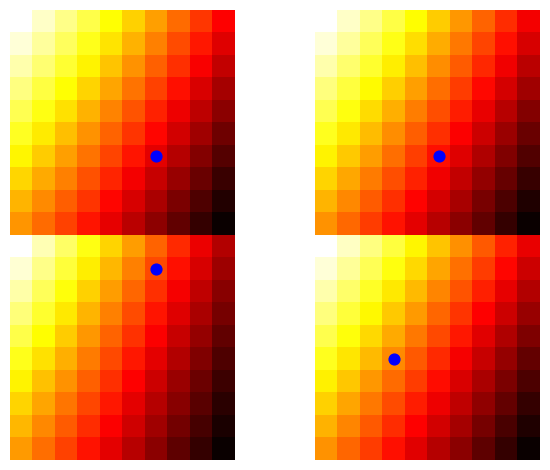


Updates 380, Steps 2438400, FPS 10773
Over the last 10 episodes:
    - episode.reward: -0.2062398121818257
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4891836969726688
    - inferred_episode_reward: 24.877361249923705
    - value_loss: 60.50359687805176
    - action_loss: 0.008383719436824321
    - dist_entropy: 1.6799561500549316
    - irl_loss: 0.28902418315410616
    - reward_lr: 0.00087984


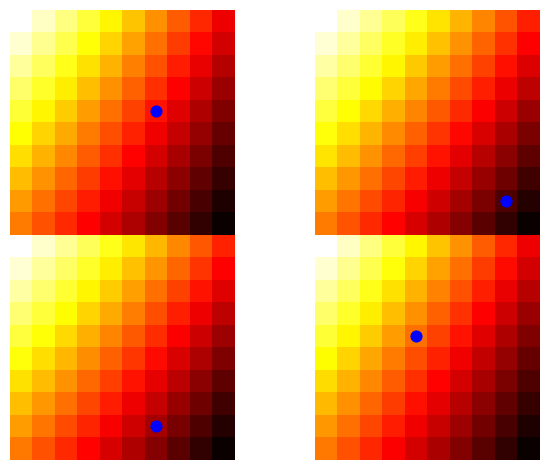


Updates 390, Steps 2502400, FPS 10658
Over the last 10 episodes:
    - episode.reward: 0.004402494450579843
    - episode.score: 0.1
    - episode.distance_to_goal: 0.33409493892024783
    - inferred_episode_reward: 11.465967750549316
    - value_loss: 51.40423469543457
    - action_loss: -0.008288843103218823
    - dist_entropy: 1.68079571723938
    - irl_loss: 0.29094517827033994
    - reward_lr: 0.0008766399999999999


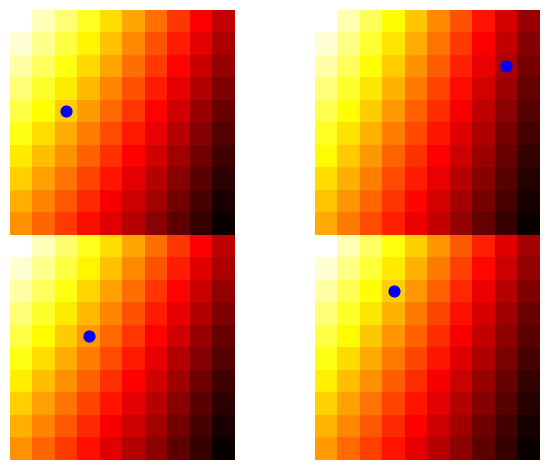


Updates 400, Steps 2566400, FPS 9447
Over the last 10 episodes:
    - episode.reward: -0.10247462461565666
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3472541600089154
    - inferred_episode_reward: 10.494880270957946
    - value_loss: 53.38157691955566
    - action_loss: -0.004016838270763401
    - dist_entropy: 1.6803954601287843
    - irl_loss: 0.30695114433765414
    - reward_lr: 0.00087344


<Figure size 640x480 with 0 Axes>

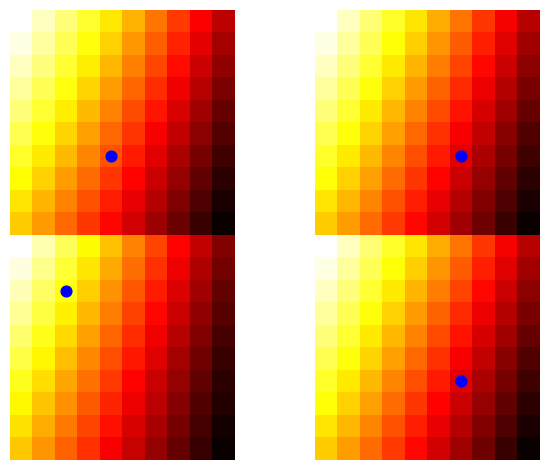


Updates 410, Steps 2630400, FPS 7812
Over the last 10 episodes:
    - episode.reward: -0.10056231653793399
    - episode.score: 0.0
    - episode.distance_to_goal: 0.47998601938961716
    - inferred_episode_reward: 10.889745855331421
    - value_loss: 28.417149162292482
    - action_loss: 0.0019548517186194657
    - dist_entropy: 1.6807557344436646
    - irl_loss: 0.3069407522678375
    - reward_lr: 0.0008702399999999999


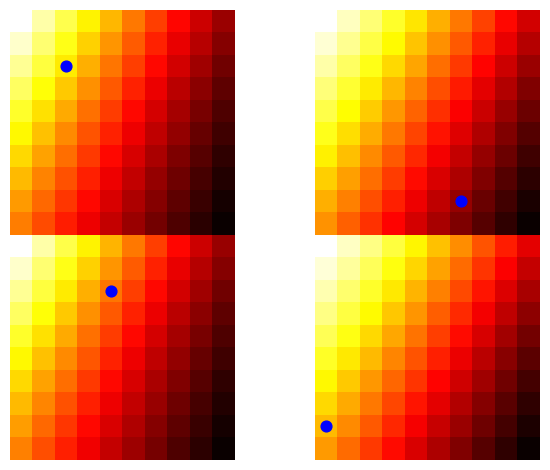


Updates 420, Steps 2694400, FPS 9551
Over the last 10 episodes:
    - episode.reward: 0.00040703494951299256
    - episode.score: 0.0
    - episode.distance_to_goal: 0.36069451549977494
    - inferred_episode_reward: 2.1848970904946325
    - value_loss: 31.974011993408205
    - action_loss: -0.013831341612967663
    - dist_entropy: 1.6805555820465088
    - irl_loss: 0.30374154150485994
    - reward_lr: 0.00086704


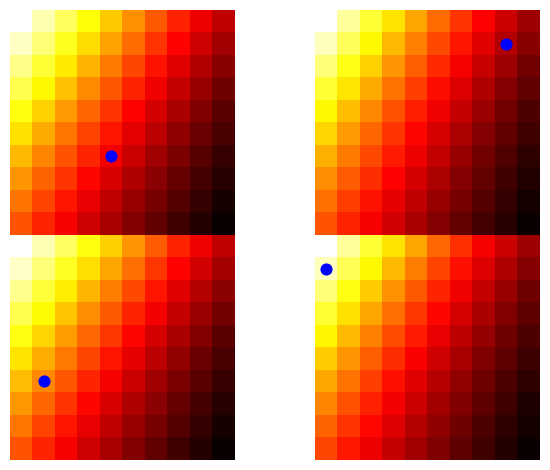


Updates 430, Steps 2758400, FPS 10028
Over the last 10 episodes:
    - episode.reward: -0.20337341763231326
    - episode.score: 0.0
    - episode.distance_to_goal: 0.47311880285204155
    - inferred_episode_reward: 6.032900996506214
    - value_loss: 30.724297523498535
    - action_loss: -0.0015561234846245497
    - dist_entropy: 1.681115984916687
    - irl_loss: 0.3148531556129456
    - reward_lr: 0.0008638399999999999


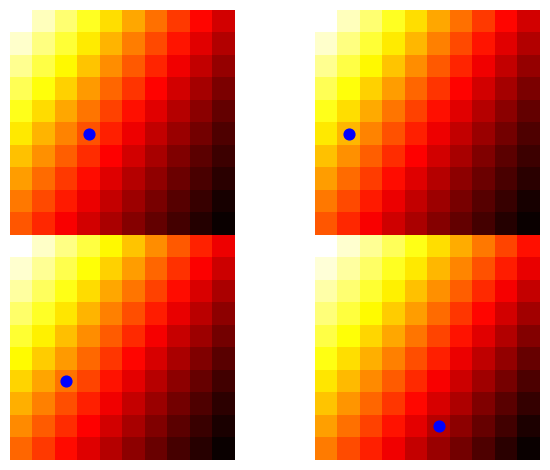

In [86]:




# Storage for the rollouts
obs = envs.reset()
td = TensorDict({"observation": obs}, batch_size=[cfg.num_envs])
print(td["observation"][0])
# Storage for the rollouts
storage_td = TensorDict({}, batch_size=[cfg.num_envs, cfg.num_steps], device=device)

for update_i in range(start_update, num_updates):
    is_last_update = update_i == num_updates - 1
    for step_idx in range(cfg.num_steps):
        # Collect experience.
        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])

        td["next_observation"] = next_obs
        for env_i, info in enumerate(infos):
            if "final_obs" in info:
                td["next_observation"][env_i] = info["final_obs"]
        td["reward"] = reward.reshape(-1, 1)
        td["done"] = done
    
        storage_td[:, step_idx] = td

        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
    
    # Call method specific update function
    updater.update(policy, storage_td, logger, envs=envs)



    if cfg.log_interval != -1 and (
        update_i % cfg.log_interval == 0 or is_last_update
    ):
        logger.interval_log(update_i, steps_per_update * (update_i + 1))
        height = 2
        width = 2
        eval_env = SnakeEnv(cfg.env.env_settings.params.config)
        fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})

        last_reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))

        for i in range(height):
            for j in range(width):
                
                reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))
                apple_pos = eval_env.reset()[0][:2]
                #test what you got so far by plotting a heat map of the reward using the snake only 
                for x in range(eval_env.screen_width//eval_env.block_size):
                    for y in range(eval_env.screen_height//eval_env.block_size ):
                        x_grid = x * eval_env.block_size / eval_env.screen_width
                        y_grid = y * eval_env.block_size / eval_env.screen_height
                        reward_map[x,y] = updater.reward(next_obs = torch.tensor([*apple_pos,x_grid,y_grid]+[0]*(eval_env.observation_space.shape[0]-4),dtype=torch.float32).to(device).view(1,1,-1))
                # for x in range(eval_env.screen_width//eval_env.block_size):
                #     for y in range(eval_env.screen_height//eval_env.block_size ):
                #         print(f"{reward_map[x,y]:.2f}", end=" ")
                #     print()
                    
                # Define the color map
                cmap = plt.cm.get_cmap('hot')

                # Plot the reward map without axis and numbers
                image = ax[i,j].imshow(reward_map, cmap=cmap, interpolation='nearest')
                ax[i,j].axis('off')

                # Plot the apple
                ax[i,j].scatter(
                    apple_pos[1] * eval_env.screen_height // eval_env.block_size,
                    apple_pos[0] * eval_env.screen_width // eval_env.block_size,
                    c='blue',
                    s=60
                )
                # map_diff = reward_map - last_reward_map
                # for x in range(eval_env.screen_width//eval_env.block_size):
                #     for y in range(eval_env.screen_height//eval_env.block_size ):
                #          print(f"{reward_map[x,y]:.2f}", end=" ")
                #     print()
                    
                # print("reward_maps diff " ,np.linalg.norm(reward_map-last_reward_map))
                last_reward_map = reward_map
        plt.tight_layout()
        plt.show()
        # for x in range(eval_env.screen_width//eval_env.block_size):
        #     for y in range(eval_env.screen_height//eval_env.block_size ):
        #         print(f"{reward_map[x,y]:.2f}", end=" ")
        #     print()

    if cfg.save_interval != -1 and (
        (update_i + 1) % cfg.save_interval == 0 or is_last_update
    ):
        save_name = osp.join(logger.save_path, f"ckpt.{update_i}.pth")
        torch.save(
            {
                "policy": policy.state_dict(),
                "updater": updater.state_dict(),
                "update_i": update_i,
            },
            save_name,
        )
        print(f"Saved to {save_name}")
        eval_info["last_ckpt"] = save_name

logger.close()
print(eval_info)

In [ ]:
ckpt = torch.load(save_name)
updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
policy.load_state_dict(ckpt["policy"])


<All keys matched successfully>

In [ ]:
import pygame

In [ ]:
cfg.env.env_settings.params.config["render_mode"] = "human"

In [ ]:
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

while True:

    obs = envs.reset()
    td = TensorDict({"observation": obs}, batch_size=cfg.num_envs)
    terminated = False 
    while not terminated : 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()

        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])
        envs.render(mode="human")
        td["next_observation"] = next_obs
        td["reward"] = reward.reshape(-1, 1)

        td["done"] = done

        td["observation"] = next_obs
        terminated = done[0]
        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
        pygame.time.wait(100)

error: display Surface quit